# Imports

In [1]:
# fit notebook width
from IPython.display import display, HTML
# display(
#     HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from importlib import reload

# MONGODB
import pymongo
from pymongo import MongoClient
# # Ploting
import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from vincenty import vincenty
# # Data and processing
# import swifter
# import datetime
import numpy as np
import pandas as pd
# import numba
# import scipy
# from sklearn.neighbors import KDTree
# # Printing
# import pprint

import sys
sys.path.append('git/PRIM/source/')

import CustomUtils
import Trips
import DataProcessing
import Plotting
import TripsProcessing
import OsmProcessing

%load_ext autoreload
%aimport pandas, numpy, matplotlib, seaborn, os, sys, ipyparallel, pprint, folium, datetime
%autoreload 2

# Load Raw Data

## Inits

In [2]:
# mongo client
client = MongoClient()
# iris collection "db.iris_geo_coords"
irisCollection = client.congestion.iris_geo_coords
# coyote data "db.coyote"
coyoteData = client.congestion.coyote2

#### IRIS Data

In [ ]:
illeEtVilaineIRIS = DataProcessing.builIrisDataFrame(irisCollection)
illeEtVilaineIRIS.head(3)

,INSEE_code_commune,INSEE_iris_code,_id,code_dept,code_region,commune_name,iris_code,iris_name,loc
0,35097,350970000,5a78810206934d227f33e962,35,53,Domalain,0000,Domalain,"{'type': 'Polygon', 'coordinates': [[[48.03916..."
1,35045,350450000,5a78810f06934d227f33eb0b,35,53,Bruc-sur-Aff,0000,Bruc-sur-Aff,"{'type': 'Polygon', 'coordinates': [[[47.83375..."
2,35352,353520101,5a78813106934d227f33ef2d,35,53,Vern-sur-Seiche,0101,Nord,"{'type': 'Polygon', 'coordinates': [[[48.06983..."


#### Logs Data

In [ ]:
df = DataProcessing.loadProjectedRawData(coyoteData, projection={
                                'country': 0, 'heading': 0, 'road': 0, 'INSEE_iris_code': 0, 'type': 0})
df.head(3)

,_id,heading_road,id,loc,matching_road,speed,time
2673938,5beaa3722958a75413a7a9ff,0,0918c9d7de15f455fc7c9af133eeb15e,"{'coordinates': [-1.27828, 48.07563], 'type': ...",633941610,100,2018-11-13 10:58:52
3184202,5beaa3722958a75413a7a606,1,d6f6504ea06ac5c040471ab90de764e6,"{'coordinates': [-1.70526, 48.10529], 'type': ...",5097960,0,2018-11-13 10:58:52
3278974,5beaa3722958a75413a7aa92,0,dd36f303e9318a993a77fae87f81443c,"{'coordinates': [-1.71984, 48.18127], 'type': ...",111850247,103,2018-11-13 10:58:52


# Data Processing

#### Building trips

In [ ]:
trips = Trips.buildTripsTuple(df)

grouping data points by car : ....

grouping data points by car : Done

took 114.1 s
extracting trips : ....



#### Filtering Trips

In [ ]:
filterdTrips = Trips.filterTrips(
    trips, irisFilter=illeEtVilaineIRIS.INSEE_iris_code.values,minDistance = 0.2,minDuration=60)
# filterdTrips = Trips.filterTrips(
#     trips, irisFilter=['N/A'])
# filterdTrips.head(1)

In [13]:
len(filterdTrips)

87155

In [ ]:
filterdTrips.head(2)

#### Plotting Trips

In [ ]:
interact(
    Plotting.printmap,
    trips=fixed(filterdTrips),
    carID=widgets.Dropdown(options=list(filterdTrips.id.unique())))

# OD Matrix

#### Building OD Matrix 

In [ ]:
OdMatrix = TripsProcessing.buildOdMatrix(filterdTrips, illeEtVilaineIRIS)
irisFlow = TripsProcessing.irisFlowRate(OdMatrix)

In [14]:
Plotting.dataFrameAsImage(OdMatrix.replace(0, np.nan), cmap=plt.cm.hot)

NameError: name 'OdMatrix' is not defined

# Recurrent trips / Density clusters

### grouping trip edges

In [60]:
roiDF = TripsProcessing.getGroupedTripEdges(filterdTrips)

In [61]:
roiDF = TripsProcessing.filterEdgesLength(roiDF, minPoints=10)

### Kmeans on cluster time attempt

In [17]:
import sklearn

In [18]:
roiClusters = TripsProcessing.findAllUsersROI(roiDF, min_samples=5,eps=0.35,both=True)
roiDF = roiDF.join(roiClusters, on='id')

In [19]:
def clusterTime(timeSeries, clusters):
    timeSeries = pd.to_timedelta(timeSeries).dt.seconds
    clusts = set(clusters)
    results = {'centroid': [], 'counts': []}
    for clust in clusts:
        values = timeSeries[np.where(clusters == clust)[0]]
        initV = np.array([pd.Timedelta(1, unit='h').seconds, pd.Timedelta(6, unit='h').seconds, pd.Timedelta(
            12, unit='h').seconds, pd.Timedelta(18, unit='h').seconds, pd.Timedelta(23, unit='h').seconds]).reshape(-1, 1)
        values = values.values.reshape(-1, 1)
        values = np.concatenate([initV, values])
        centroid, label, inertia = sklearn.cluster.k_means(
            values, 5, init=initV, n_init=1)
        _, counts = np.unique(label, return_counts=True)
        results['centroid'].append(centroid.reshape(-1))
        results['counts'].append(counts)
    return results

In [20]:
kmeans_results = roiDF.apply(lambda x: pd.Series(clusterTime(pd.Series(
    [*x['edges_begin_time'], *x['edges_end_time']]), x['both_clusters'])), axis=1)

In [21]:
kmeans_results_counts = pd.DataFrame(
    np.concatenate(kmeans_results.counts.values))

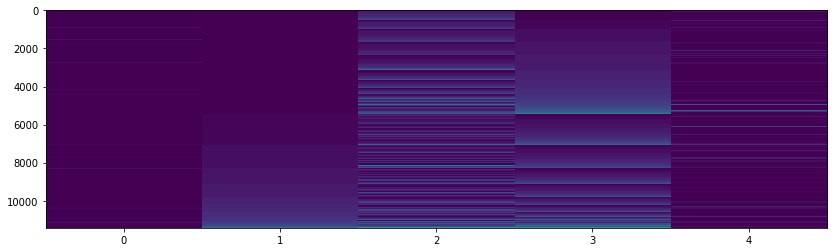

In [22]:
plt.figure(figsize=(14, 4))
plt.imshow(kmeans_results_counts.sort_values([1, 3, 2]), aspect='auto')

### finding recurrent trips

In [23]:
tripClusters = roiDF.apply(
    TripsProcessing.recurentTrips, axis=1, min_samples=5)
roiDF = roiDF.assign(trip_clusters=tripClusters)
roiDF = roiDF.assign(
    n_trip_clusters=roiDF.trip_clusters.apply(lambda x: len(set(x))))

In [24]:
roiDF.head()

,edges_begin,edges_end,edges_begin_time,edges_end_time,edges_trip_id,length,both_n_clusters,both_clusters,trip_clusters,n_trip_clusters
id,,,,,,,,,,
001a7cb7f9a28b9e14bb3aae4798890e,"[[-1.68415, 48.16132], [-1.68411, 48.16158], [...","[[-1.70757, 48.15175], [-1.72485, 48.1983], [-...","[2018-11-16T08:21:09.000000000, 2018-11-17T11:...","[2018-11-16T08:32:36.000000000, 2018-11-17T12:...","[102, 110, 111, 113, 121, 125, 132, 140, 142]",18,2,"[0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1]",1
002b0e76e4ec0fd69f14e755314a6246,"[[-1.70028, 48.08748], [-1.69565, 48.08544], [...","[[-1.70736, 48.08596], [-1.61709, 48.10523], [...","[2018-11-17T10:32:26.000000000, 2018-11-19T13:...","[2018-11-17T10:43:57.000000000, 2018-11-19T13:...","[180, 195, 197, 213, 215]",10,1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]",1
0033acd31e85c126809b07131618c254,"[[-1.90712, 48.51457], [-1.83451, 48.48701], [...","[[-1.87675, 48.50181], [-1.7556, 48.5506], [-1...","[2018-11-16T21:15:48.000000000, 2018-11-17T10:...","[2018-11-16T21:27:08.000000000, 2018-11-17T10:...","[250, 252, 253, 254, 255, 256, 258, 260, 262, ...",52,2,"[-1, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1
00486eee9094591e830b14e74f7c7696,"[[-1.21909, 48.11578], [-1.18399, 48.11335], [...","[[-1.18252, 48.11417], [-1.21914, 48.11592], [...","[2018-11-17T14:05:07.000000000, 2018-11-17T14:...","[2018-11-17T14:14:07.000000000, 2018-11-17T15:...","[371, 372, 375, 376, 378, 390, 395, 396, 397, ...",68,3,"[0, -1, 0, 0, -1, 0, 0, 1, -1, -1, -1, -1, -1,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1
00489cdbbdbc16112bb28e36687399c2,"[[-1.61083, 48.26206], [-1.52182, 48.29928], [...","[[-1.52182, 48.29928], [-1.33972, 48.34176], [...","[2018-11-13T15:19:07.000000000, 2018-11-13T16:...","[2018-11-13T16:15:48.000000000, 2018-11-13T17:...","[473, 474, 480, 482, 485, 487, 488, 491, 493, ...",24,1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]",1


In [25]:
roiDF = roiDF[roiDF.n_trip_clusters >= 3]

In [26]:
userEdges = roiDF.sample().iloc[0]
userEdges

edges_begin         [[-1.40073, 48.25789], [-1.40694, 48.25484], [...
edges_end           [[-1.40694, 48.25484], [-1.39789, 48.26046], [...
edges_begin_time    [2018-11-13T20:27:39.000000000, 2018-11-14T08:...
edges_end_time      [2018-11-13T20:33:41.000000000, 2018-11-14T08:...
edges_trip_id       [109380, 109381, 109382, 109383, 109385, 10938...
length                                                            118
both_n_clusters                                                     2
both_clusters       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0,...
trip_clusters       [0, 1, 0, 1, 0, 1, 0, 1, 0, -1, -1, 0, 1, 0, 0...
n_trip_clusters                                                     3
Name: 40f4639f570e1ac39e747ba68baf4908, dtype: object

In [27]:
Plotting.plotUserRegionsOfInterst(userEdges, show_outliers=True)

AttributeError: 'Series' object has no attribute 'clusters_begin'

In [ ]:
Plotting.plotUserTripsClusters(
    Plotting.getFoliumMap(), trips, userEdges, edges_only=True)

In [ ]:
stats = TripsProcessing.getAllClusterStats(
    trips, userEdges).assign(trip_clusters=userEdges.trip_clusters)


In [ ]:
stats.groupby(['clusterEnd','clusterBegin'])['deltaTimeBegin'].apply(np.mean).unstack('clusterEnd').fillna(0)

In [ ]:
stats.groupby(['clusterBegin','clusterEnd']).size().unstack('clusterEnd').fillna(0)

In [ ]:
stats.groupby(['clusterBegin','clusterEnd']).describe().T

In [ ]:
stats.groupby(['clusterBegin']).describe().T

### Mining Day sequences

In [62]:
roiClusters = TripsProcessing.findAllUsersROI(roiDF, min_samples=5,eps=0.35,both=True)
roiDF = roiDF.join(roiClusters, on='id')

In [63]:
def alignClustersWithPoints(userEdges):
    df = pd.DataFrame(data=np.array([[*userEdges['edges_begin_time'],*userEdges['edges_end_time']],[*userEdges['edges_begin'],*userEdges['edges_end']],userEdges['both_clusters']]),index=['time','loc','cluster']).T
    df= df.assign(date = pd.to_datetime(df.time).apply(lambda x : x.date()))
    return df

In [64]:
def headAndTail(x,n=1):
    return  x.head(n).append(x.tail(n))

In [65]:
def getClusterWithMaxStartEndProba(userEdges):
    alignedClusters = alignClustersWithPoints(userEdges).sort_values('time')
    
    startEndSequence = alignedClusters.groupby('date')\
                                      .apply(headAndTail)\
                                      .cluster
    
    nbSequences = len(startEndSequence)
    
    nbTrips = len(alignedClusters)
    
    mostStartEndCluster =startEndSequence.value_counts(True)\
                                         .agg([pd.Series.idxmax,max]) 
    
    tripPropsOfCluster = alignedClusters.cluster.value_counts(True)[mostStartEndCluster['idxmax']]
        
    locCluster = alignedClusters.groupby('cluster')['loc'].apply(np.mean)[mostStartEndCluster['idxmax']]
    maxCluster =pd.Series(
                            {  
                                'idCluster'  : mostStartEndCluster['idxmax'],
                                'seqProps'   : mostStartEndCluster['max'],
                                'nbSequences': nbSequences,
                                'tripProps'  : tripPropsOfCluster,
                                'nbTrips'    : nbTrips,
                                'loc'        : locCluster
                            }
                         )
                                    
    return maxCluster

In [66]:
clusterData = roiDF.apply(lambda x : getClusterWithMaxStartEndProba(x),axis = 1)

In [ ]:
clusterData = clusterData[(clusterData.idCluster!=-1)&(clusterData.seqProps>0.5)&(clusterData.nbSequences>=10)&(clusterData.seqProps>clusterData.tripProps)]

### Plotting users homes

In [38]:
def plotUsersHomes(usersData,usersHome,usersID):
    folium_map = Plotting.getFoliumMap()
    for data , home,userID in zip(usersData,usersHome,usersID):

        name = userID
        layer = getUserHomeLayer(data,home,folium_map,name)
        layer.add_to(folium_map)
    folium.LayerControl(collapsed=False).add_to(folium_map)
    return folium_map


def getUserHomeLayer(userData,userHome,fmap,name="layer",predictedHome = None):
    layer = folium.plugins.FeatureGroupSubGroup(fmap,name=name)
    if type(userData)==numpy.ndarray :
        locations = [loc[::-1]for loc in userData]
    else : 
        locations = [loc['coordinates'][::-1]for loc in userData.values]
    [folium.CircleMarker(loc,radius=1).add_to(layer) for loc in locations]
    folium.CircleMarker(userHome[::-1],radius=20,color='red',fill_color='pink',fill_opacity=0.7).add_to(layer)
    
    if predictedHome!=None :
        print('predictedHome',predictedHome)
        [folium.CircleMarker(loc[::-1],radius=17,color='green',fill_color='pink',fill_opacity=0.7).add_to(layer) for loc in predictedHome]
    return layer


In [39]:
sampleUsers = clusterData.sample(10)

In [ ]:
#sampleUsers = clusterData.loc[[userIDS]]

In [ ]:
pts = [df[df.id==userid]['loc'] for userid in sampleUsers.index]

In [ ]:
homes = sampleUsers['loc'].values

In [ ]:
fmap = plotUsersHomes(pts,homes,sampleUsers.index)

In [ ]:
fmap.save('home.html')

In [ ]:
tripsSample = trips.copy()

## Compute clusters and cluster stats for each car

In [ ]:
def innerListToNpArray(df,cols):
    for col in cols :
        df[col]=df[col].apply(np.array)
def groupLocations(tripsDF,**kwds):
    df = tripsDF[['id','begin','end']].agg({                      'id'    :  lambda x : x,
                                                                  'begin' : [lambda x : x['loc']['coordinates'], lambda x : x['time'], lambda x : x['speed']],
                                                                  'end'   : [lambda x : x['loc']['coordinates'], lambda x : x['time'], lambda x : x['speed']],
                                                                })
    df.columns.set_levels(['id','begin_loc','begin_time','begin_speed','end_loc','end_time','end_speed'],level=1,inplace=True)
    df.columns.set_labels(range(7),level=1,inplace=True)
    df.columns=df.columns.droplevel()
    df = df.groupby('id').agg(lambda x : [*x.values])
    df['loc']=df['begin_loc']+df['end_loc']
    df['time']=df['begin_time']+df['end_time']
    df['speed']=df['begin_speed']+df['end_speed']
    df['cluster']=df['loc'].apply(TripsProcessing.findUserRegionsOfInterst,**kwds)
    innerListToNpArray(df,cols= ['loc','time','speed','cluster'])
    
    return df[['loc','time','speed','cluster']]

In [ ]:
def getStats(userData):
    userDF=pd.DataFrame(list(zip(*userData.values)),columns=['loc','time','speed','cluster'])
    userDF.time=userDF.time.apply(lambda x: x.hour)
    df=userDF.groupby('cluster').describe()
    df=df.drop(['count'],axis=1,level=1)
    df.columns=df.columns.map('_'.join)

    beginDesc =userDF[:int(len(userDF)/2)][['time','cluster']].groupby('cluster').describe()
    beginDesc.columns=beginDesc.columns.map('_Begin_'.join)
    beginDesc.time_Begin_count =beginDesc.time_Begin_count/(len(userDF)/2)
    
    endDesc =userDF[int(len(userDF)/2):][['time','cluster']].groupby('cluster').describe()
    endDesc.columns=endDesc.columns.map('_End_'.join)
    endDesc.time_End_count=endDesc.time_End_count/(len(userDF)/2)
    df = df.join(beginDesc.join(endDesc))
    df=df.assign(loc_std=userDF.groupby('cluster')['loc'].apply(lambda x: np.sqrt(np.mean([CustomUtils.reverseVincenty(y,np.mean(x))**2 for y in x]))))
    df.reset_index(inplace = True)
    df=df.assign(id=userData.name)
    df=df.assign(loc=userDF.groupby('cluster')['loc'].apply(np.mean).values)
    return df

In [ ]:
def getLabeledLocations(locationsStats, clusterData):


    labeledLocations = locationsStats[locationsStats.id.isin(clusterData.index)]

    labeledLocations=labeledLocations.assign(home_loc=clusterData['loc'].loc[labeledLocations.id[labeledLocations.id.isin(clusterData.index)]].values)

    labeledLocations=labeledLocations.assign(home=labeledLocations[['loc','home_loc']].apply(lambda x : CustomUtils.reverseVincenty(x['loc'],x['home_loc'])<0.2,axis=1).values)

    labeledLocations.reset_index(drop=True,inplace=True)
    
    return labeledLocations

In [ ]:
groupedLocations =  groupLocations(trips, returnNbCluster=False)
locationsStats = pd.concat(groupedLocations.apply(getStats,axis=1).values)


In [ ]:
labeledLocations = getLabeledLocations(locationsStats,clusterData)

In [ ]:
def getXData(groupedLocations,locationsStats):
    counts=groupedLocations['cluster'].apply(lambda x: numpy.unique(x,return_counts=True)[1])
    npoints=counts.apply(sum)
    clustersCounts=numpy.concatenate(counts.values)
    print(len(clustersCounts))
    df=locationsStats.assign(clustersCounts=clustersCounts)
    df=df.assign(clusterProp=df.clustersCounts.values/npoints.loc[df.id].values)
    residentialLand = df['loc'].apply(lambda x: DataProcessing.isResidential(x.tolist()))
    df = df.assign(residentialLand=residentialLand)
    return df
clustersStats =getXData(groupedLocations,locationsStats)

In [ ]:
clustersStats.fillna(0.0)[clustersStats.cluster!=-1].id.nunique()

In [ ]:
fullX=clustersStats.fillna(0.0)[clustersStats.cluster!=-1].drop(['id','cluster','loc'],axis=1)

In [ ]:
data=labeledLocations.fillna(0.0)[labeledLocations.cluster!=-1]
X=data.drop(['id','cluster','loc','home_loc','home'],axis=1)
y=data['home']

In [ ]:
def trainAndPredictRF(X,y,classifier,test_size=0.2):
    x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=test_size,)
    classifier.fit(x_train,y_train)
    y_train
    y_pred=classifier.predict(x_test)
    fullpred= classifier.predict(X)
    print(sklearn.metrics.confusion_matrix(classifier.predict(x_train),y_train))
    print('cohen kappa ',sklearn.metrics.cohen_kappa_score(y_test,y_pred))
    return fullpred,sklearn.metrics.confusion_matrix(y_test,y_pred),classifier

In [ ]:
data.home.value_counts()

In [ ]:
preds,cm,classifier=trainAndPredictRF(X,y,sklearn.ensemble.RandomForestClassifier(n_estimators=50,class_weight={True: 1, False: 5}))
cm

In [ ]:
fullPreds  = clustersStats.fillna(0.0)[clustersStats.cluster!=-1].assign( preds = classifier.predict(fullX))

In [ ]:
fullPreds.groupby('id')['preds'].sum().value_counts()

In [ ]:
plt.figure(figsize=(36,4))
plt.bar(range(len(classifier.feature_importances_)),classifier.feature_importances_,tick_label=X.columns.values)
plt.tight_layout()

In [ ]:
predLocations  = labeledLocations.dropna().assign(pred=preds)

In [ ]:
predictedHomes = predLocations[['id','loc','pred']][predLocations.pred==True].groupby('id').agg(lambda x : [*x.values])['loc']

In [ ]:
xUserIds=labeledLocations.dropna()[labeledLocations.id==userIDS].drop(['id','cluster','loc','home_loc','home'],axis=1)
predLocations[labeledLocations.id==userIDS]

In [ ]:
def plotClusters(groupedLocations,labeledLocations,predictedHomes,userIDS):
    folium_map=Plotting.getFoliumMap()
    predictedHome = predictedHomes.loc[userIDS] if userIDS in predictedHomes.index else None
    layer = getUserHomeLayer(groupedLocations.loc[userIDS]['loc'],labeledLocations[(labeledLocations.home==True)& (labeledLocations.id==userIDS)]['loc'].iloc[0],folium_map,predictedHome=predictedHome)
    layer.add_to(folium_map)
    folium.LayerControl(collapsed=False).add_to(folium_map)
    return folium_map

In [ ]:
classifier.predict_proba(xUserIds)

In [ ]:
userIDS =predLocations[(predLocations.pred!=predLocations.home)&(predLocations.pred==True)].id.sample(1).values[0]
plotClusters(groupedLocations,labeledLocations,predictedHomes,userIDS)

In [ ]:
sklearn.model_selection.cross_validate(sklearn.ensemble.AdaBoostClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=10)),X,y,cv=10)

In [ ]:
oneUser=groupedLocations.iloc[0]

In [ ]:
def getStatsMan(userData):
    userDF=pd.DataFrame(list(zip(*userData.values)),columns=['loc','time','speed','cluster'])
    userDF.time=userDF.time.apply(lambda x: x.hour)    
    df=userDF.groupby('cluster').describe()
    df=df.drop(['count'],axis=1,level=1)
    df.columns=df.columns.map('_'.join)
    df=df.assign(loc_std=userDF.groupby('cluster')['loc'].apply(lambda x: np.sqrt(np.mean([CustomUtils.reverseVincenty(y,np.mean(x))**2 for y in x]))))
    df.reset_index(inplace = True)
    df=df.assign(id=userData.name)
    df=df.assign(loc=userDF.groupby('cluster')['loc'].apply(np.mean).values)
    return df

In [ ]:
getStatsMan(oneUser)

In [ ]:
1+1

In [ ]:
1+1

In [74]:
1+1

2